In [10]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
from functools import reduce

from sklearn import linear_model,metrics,calibration

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [145]:
def plot_calibration_curve(mean_predicted_value,fraction_of_positives):
    # Create the calibration curve plot
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Logistic Regression')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend(loc='best')
    plt.show()
    
def plot_calibration_curve_comparison(cal):
    long = pd.melt(cal,id_vars=['features'],value_vars=np.hstack([[f'mean_average_predicted_bin{i}' for i in range(10)],
                                                                     [f'prevalence_bin{i}' for i in range(10)]]))
    long[['level_1', 'level_2']] = long['variable'].str.split('_bin', expand=True)
    long['value'] = long['value'].astype(float)
    df_multiindex = long.pivot_table(index=['features','level_2'], columns=['level_1'], values='value')
    # Create the calibration curve plot
    fig = plt.figure(figsize=(10,10))
    plots.plot_context()
    ax = sns.lineplot(data=df_multiindex,hue='features',x='mean_average_predicted',y='prevalence',markers=True)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Curve')
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    
def plot_calibration_curve_all(calibration_all,models=['diag_ProdHC','diag_ProdallHC','diag_ProdPopulationNoPD'],
                               names=['Prodromal vs matched unaffected control','Prodromal vs unmatched unaffected control',
                            'Prodromal vs Population'],
                               features=['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD'],fnames=['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined'],save=[]):
    fig,axes = plt.subplots(nrows=3,figsize=(10,15))
    plots.plot_context()
    subplotlabels = ['A','B','C']
    for ax,model,name,label in zip(axes.flatten(),models,names,subplotlabels):
        cal = calibration_all.loc[(model,features),(slice(None),0)].droplevel(level=1,axis=1).reset_index()
        long = pd.melt(cal,id_vars=['features'],value_vars=np.hstack([[f'mean_average_predicted_bin{i}' for i in range(10)],
                                                                         [f'prevalence_bin{i}' for i in range(10)]]))
        long[['level_1', 'level_2']] = long['variable'].str.split('_bin', expand=True)
        long['value'] = long['value'].astype(float)
        df_multiindex = long.pivot_table(index=['features','level_2'], columns=['level_1'], values='value')
        # Create the calibration curve plot
        l = sns.lineplot(data=df_multiindex,hue='features',x='mean_average_predicted',y='prevalence',marker='s',ax=ax,hue_order=features)
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(name)
        if model == 'diag_ProdHC':
            ax.legend(bbox_to_anchor=(1,1),labels=fnames)
        else:
            ax.legend([],[],frameon=False)
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
            size=20, weight='bold')
    plt.tight_layout()
    if save:
        plt.savefig(f'{save}_calibration.pdf',dpi=300,bbox_inches='tight')
        plt.savefig(f'{save}_calibration.png',dpi=300,bbox_inches='tight')

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/noOsteo'

In [72]:
# recompute tpr,fpr,recall, precision and save correctly
models = ['diag_PDHC','diag_ProdHC','diag_PDProdHC','diag_PDallHC','diag_ProdallHC','diag_PDProdallHC','diag_PDPopulationNoProd','diag_ProdPopulationNoPD',
          'diag_PDProdPopulation']
models0 = ['diag_PDHC','diag_ProdHC','diag_PDProdHC','diag_PDHC','diag_ProdHC','diag_PDProdHC','diag_PDPopulationNoProd','diag_ProdPopulationNoPD',
          'diag_PDProdPopulation']
kinds = ['HC','HC','HC','allHC','allHC','allHC','pop','pop','pop']
features = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','acc','all_acc_features',
            'genetics+family+all_acc_features','lifestyle+all_acc_features','blood+all_acc_features','prodromalsigns_beforePD+all_acc_features',
            'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
#stacked_features = ['genetics+family+all_acc_features','lifestyle+all_acc_features','blood+all_acc_features','prodromalsigns_beforePD+all_acc_features',
#            'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
#stacked_features_names = [f'{n}_stacked' for n in stacked_features]
calibration_all = pd.DataFrame(index=pd.MultiIndex.from_product([models,features],names=['model','features']),
                            columns=pd.MultiIndex.from_product([np.hstack(['mean_average_predicted','prevalence',
                                                                 [f'mean_average_predicted_bin{i}' for i in range(10)],
                                                                 [f'prevalence_bin{i}' for i in range(10)],'slope','intercept']),np.arange(5)]))

for mod,modname,kd in zip([models[:3],models[3:6],models[6:]],[models0[:3],models0[3:6],models0[6:]],
                                   [kinds[:3],kinds[3:6],kinds[6:]]):

    for i,feature in enumerate(features):
        cal = pd.DataFrame(index=pd.MultiIndex.from_product([mod,np.arange(5)],names=['model','cv']),
                                columns=np.hstack(['mean_average_predicted','prevalence',
                                                                 [f'mean_average_predicted_bin{i}' for i in range(10)],
                                                                 [f'prevalence_bin{i}' for i in range(10)],'slope','intercept']))
        for (m,kind),modelname,model in zip(enumerate(kd),mod,modname):
            if 'stacked' in feature:
                name = modelname.replace('diag_','')
                # fname = stacked_features[i]
                # stacked = pd.read_csv(f'{data_path}/{fname}/stacked_perf.csv',index_col=[0,1],header=[0,1])
                # stacked = stacked['test']
                # performances.loc[(modelname,feature),:] = stacked.loc[name,'AUROC'].dropna().values
                # performances_pr.loc[(modelname,feature),:] = stacked.loc[name,'AUPRC'].dropna().values
                # curves.loc[(modelname,feature),('fpr',slice(None))] = stacked.loc[name,'fpr'].dropna().values
                # curves.loc[(modelname,feature),('tpr',slice(None))] = stacked.loc[name,'tpr'].dropna().values
                # curves.loc[(modelname,feature),('precision',slice(None))] = stacked.loc[name,'precision'].dropna().values
                # curves.loc[(modelname,feature),('recall',slice(None))] = stacked.loc[name,'recall'].dropna().values
            else:
                if kind == 'HC':
                    path = f'{data_path}/{feature}/HCmodels_pred_stacked_matched.csv'
                    true = pd.read_csv(f'/scratch/c.c21013066/data/ukbiobank/merged_data/unaffectedNoOsteoMatchedHC.csv').set_index('eid')
                elif kind == 'allHC':
                    path = f'{data_path}/{feature}/HCmodels_pred_stacked_allHC.csv'
                    true = pd.read_csv(f'/scratch/c.c21013066/data/ukbiobank/merged_data/unaffectedNoOsteoAllHC.csv').set_index('eid')
                elif kind == 'pop':
                    path = f'{data_path}/{feature}/popmodelsNoPD_pred_stacked_allHC.csv'
                    true = pd.read_csv(f'/scratch/c.c21013066/data/ukbiobank/merged_data/populationNoOsteoAllHC.csv').set_index('eid')
                perf = pd.read_csv(path,index_col=[0,1],header=[0,1])
                perf = perf.loc[:,(slice(None),'test')].droplevel(level=1,axis=1).loc[:,[model]].dropna()
                for cv in np.arange(5):
                    perf_cv = perf.loc[(slice(None),cv),:]
                    merged = pd.merge(perf_cv,true[[model]],right_index=True,left_index=True,how='left')
                    nona = merged.dropna(how='any',axis='rows')
                    # calibration at large: 
                    cal.loc[(modelname,cv),'mean_average_predicted'] = np.mean(nona.iloc[:,0])
                    cal.loc[(modelname,cv),'prevalence'] = np.mean(nona.iloc[:,1])
#                     # Fit linear regression model for calibration intercept and slope
#                     lin_reg = linear_model.LinearRegression()
#                     lin_reg.fit(nona.iloc[:,0].values.reshape(-1,1), nona.iloc[:,1])

#                     # Extract calibration intercept and slope
#                     calibration.loc[(modelname,cv),'intercept'] = lin_reg.intercept_
#                     calibration.loc[(modelname,cv),'slope'] = lin_reg.coef_[0]
                    # Obtain the calibration curve
                    fraction_of_positives, mean_predicted_value = calibration.calibration_curve(nona.iloc[:,1], nona.iloc[:,0], n_bins=10)
                    cal.loc[(modelname,cv),[f'mean_average_predicted_bin{i}' for i in range(10)]] = np.append(mean_predicted_value, 
                                                                                                              np.zeros(10-len(mean_predicted_value)) + np.nan)
                    cal.loc[(modelname,cv),[f'prevalence_bin{i}' for i in range(10)]] = np.append(fraction_of_positives, np.zeros(10-len(fraction_of_positives
                                                                                                                                        ))+np.nan)                   
                    #plot_calibration_curve(mean_predicted_value,fraction_of_positives)
                    # Fit a linear regression model to the calibration curve points
                    lin_reg = linear_model.LinearRegression()
                    lin_reg.fit(mean_predicted_value.reshape(-1, 1), fraction_of_positives)

                    # Extract calibration intercept and slope
                    cal.loc[(modelname,cv),'intercept'] = lin_reg.intercept_
                    cal.loc[(modelname,cv),'slope'] = lin_reg.coef_[0]
        calibration_all.loc[(mod,feature),:] = cal.unstack().values

In [144]:
calibration_all.to_csv('/scratch/c.c21013066/data/ukbiobank/analyses/acc_models/noOsteo/calibration.csv')

In [45]:
calibration_all

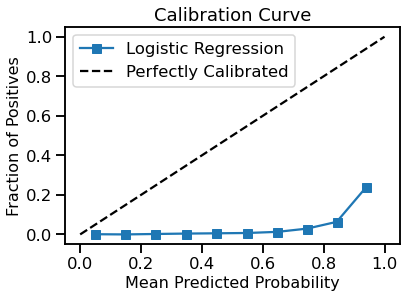

In [73]:
plot_calibration_curve(calibration_all.loc[('diag_ProdPopulationNoPD','all_acc_features'),([f'mean_average_predicted_bin{i}' for i in range(10)],0)],
                      calibration_all.loc[('diag_ProdPopulationNoPD','all_acc_features'),([f'prevalence_bin{i}' for i in range(10)],0)])

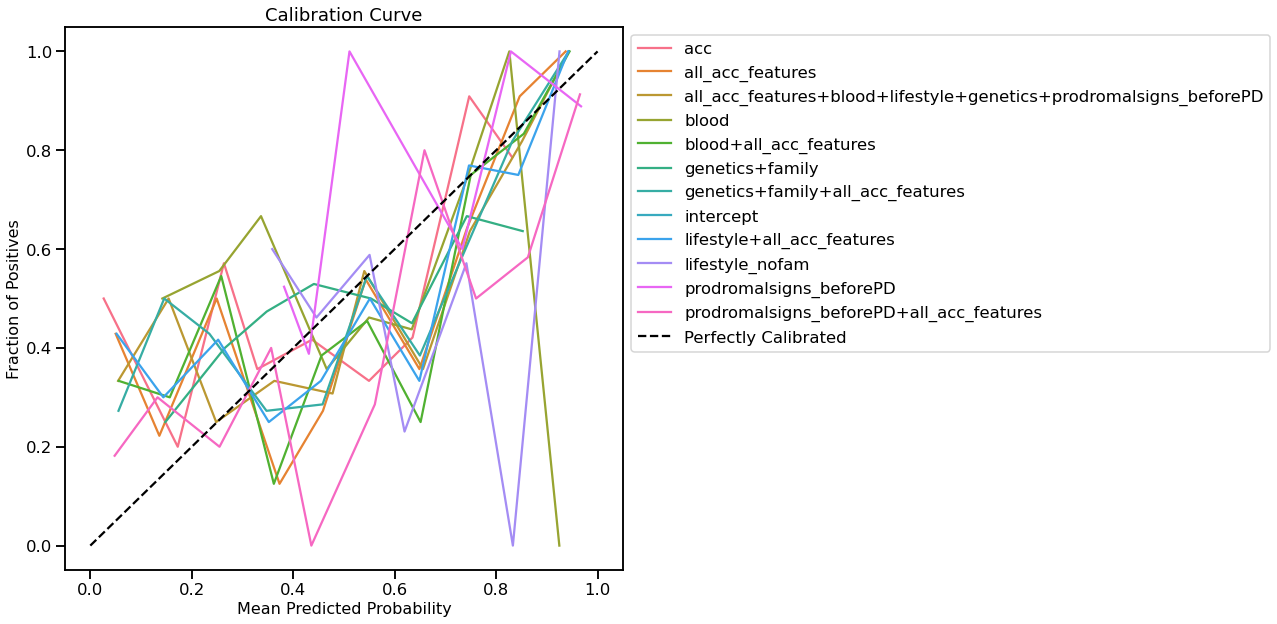

In [100]:
test = calibration_all.loc[('diag_ProdHC',slice(None)),(slice(None),0)].droplevel(level=1,axis=1)
plot_calibration_curve_comparison(test.reset_index())

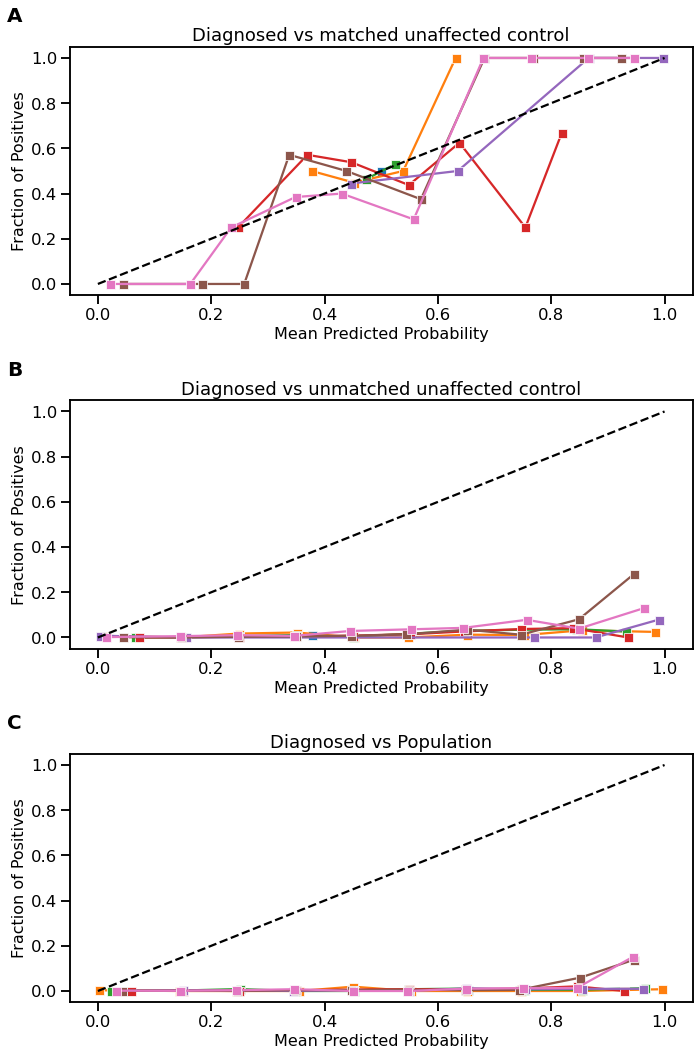

In [147]:
models = ['diag_PDHC','diag_PDallHC','diag_PDPopulationNoProd']
names = ['Diagnosed vs matched unaffected control','Diagnosed vs unmatched unaffected control',
                            'Diagnosed vs Population']
features = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforePD','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
fnames = ['no-skill','genetics+family','lifestyle','blood','prodromal symptoms',
                                                'all accelerometer','combined']
plot_calibration_curve_all(calibration_all,models,names,features,fnames,save='/scratch/c.c21013066/images/paper/ProdromalUKBB/PD')

In [83]:
long = pd.melt(test.reset_index(),id_vars=['features'],value_vars=np.hstack([[f'mean_average_predicted_bin{i}' for i in range(10)],
                                                                     [f'prevalence_bin{i}' for i in range(10)]]))

In [89]:
long[['level_1', 'level_2']] = long['variable'].str.split('_bin', expand=True)
long['value'] = long['value'].astype(float)

In [92]:
df_multiindex = long.pivot_table(index=['features','level_2'], columns=['level_1'], values='value')